In [2]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once') 

In [7]:
df=pd.read_csv('datos/bikes_preparado.csv')
df=df.drop(['Unnamed: 0'], axis=1)
df.head()

,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt_BOX
0,1,-1.0,-0.617143,4.636809,-1.460318,-4.636809,1.112473,0.454618,0.677080,1.484801,-0.628344,-0.014021,-1.348671,18.047507
1,1,-1.0,-0.617143,-0.215666,-0.965295,0.215666,1.112473,0.642695,0.577171,0.757869,0.391271,-0.530643,-1.335334,16.952659
2,1,-1.0,-0.617143,-0.215666,-0.470272,0.215666,-0.758977,-0.984891,-1.083596,-0.956453,0.388609,-0.559057,-0.869379,19.822839
3,1,-1.0,-0.617143,-0.215666,0.024751,0.215666,-0.758977,-0.949479,-0.854017,0.058056,-0.630080,-0.590054,-0.681830,20.698484
4,1,-1.0,-0.617143,-0.215666,0.519774,0.215666,-0.758977,-0.686934,-0.680718,-0.958546,-0.322158,-0.657215,-0.628483,20.845083


In [8]:
#MODELO DECISSION TREE

# al igual que en la regresión lineal tenemos que separar nuestro dataframe en X e y

X = df.drop("cnt_BOX", axis = 1)
y = df["cnt_BOX"]

In [9]:
# y dividir nuestros datos en train y test para poder evaluar la bondad de nuestro modelo

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [10]:

# creamos el objeto del modelo, al igual que hacíamos en la regresión lineal
arbol = DecisionTreeRegressor(random_state =42)  #Como no sabemos la profundidad adecuada, 
                    #dejamos que le modelo lo haga con todas las variables y más adelante, elegiremos la que mejor ha predicho los datos.


In [11]:

# ajustamos el modelo, igual que en la regresión lienal. 
arbol.fit(x_train, y_train)


DecisionTreeRegressor(random_state=42)

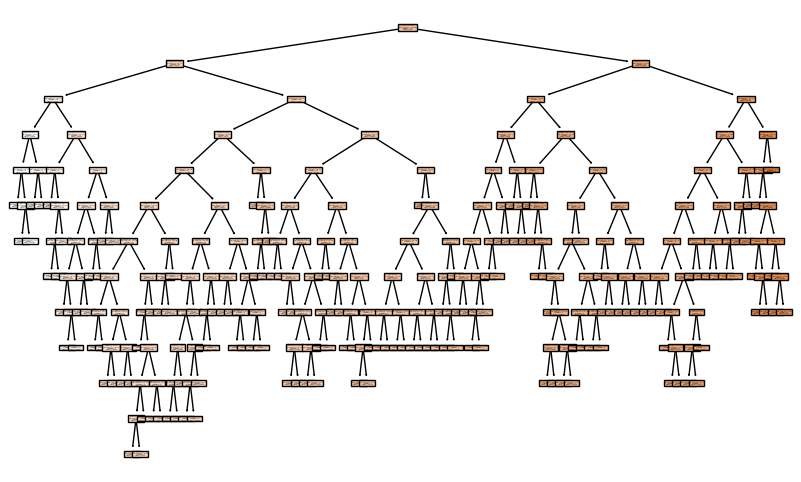

In [12]:

#Para mostrar el modelo en arbol
fig = plt.figure(figsize = (10,6))  
tree.plot_tree(arbol, feature_names = x_train.columns, filled = True)
plt.show();


In [13]:

#HIPER-PARÁMETROS

# max features. Como vemos, debemos poner en nuestro modelo una profudidad máxima de 4. 

max_features = np.sqrt(len(x_train.columns))
max_features


3.605551275463989

In [14]:


# max depth compruebo
print(arbol.tree_.max_depth)


12


In [15]:

# hacemos las predicciones sobre los dos set de datos el X_test y el X_train

y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)


In [16]:
#Métricas
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df


In [17]:


# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results1.head()


,MAE,MSE,RMSE,R2,set,modelo
0,0.529329,0.620632,0.787802,0.952561,test,Decission Tree I
1,0.000000,0.000000,0.000000,1.000000,train,Decission Tree I


In [18]:
# MODELO II DECISION TREE PARA ESTABLECER LA PROFUNDIDAD DEL PROPIO MODELO

# lo primero que tenemos que hacer es definir un diccionario con los hiperparámetros que queremos modificar 
# y los valores que queremos 

param = {"max_depth": [2,4, 6], # teniendo en cuenta que teníamos overfitting tendremos que reducir la profundidad del modelo, 
                                #la nuestra anterior era de 17. Bajaremos mucho este valor ya que teníamos un overfitting muy claro
        "max_features": [1,2,3,4],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. 
                                #Ponemos como límite el 4 ya que es el resultado de la raiz cuadrada. 

        # estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50,100]} 




In [19]:

# una vez creado el diccionario iniciaremos el modelo con GridSearch
gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1, # para que no nos printee ningún mensaje en pantalla
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva


In [20]:

# ajustamos el modelo que acabamos de definir en el GridSearch

gs.fit(x_train, y_train)


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 4, 6], 'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [21]:


# este método (BEST_ESTIMATOR) nos esta diciendo que el mejor modelo es aquel que tiene una profundidad de 6, que usa 4 
# variables predictoras para construir el modelo y que tiene  un min_samples_leaf y un min_samples_split de 10. 
mejor_modelo = gs.best_estimator_
mejor_modelo


DecisionTreeRegressor(max_depth=6, max_features=4, min_samples_leaf=10,
                      min_samples_split=10)

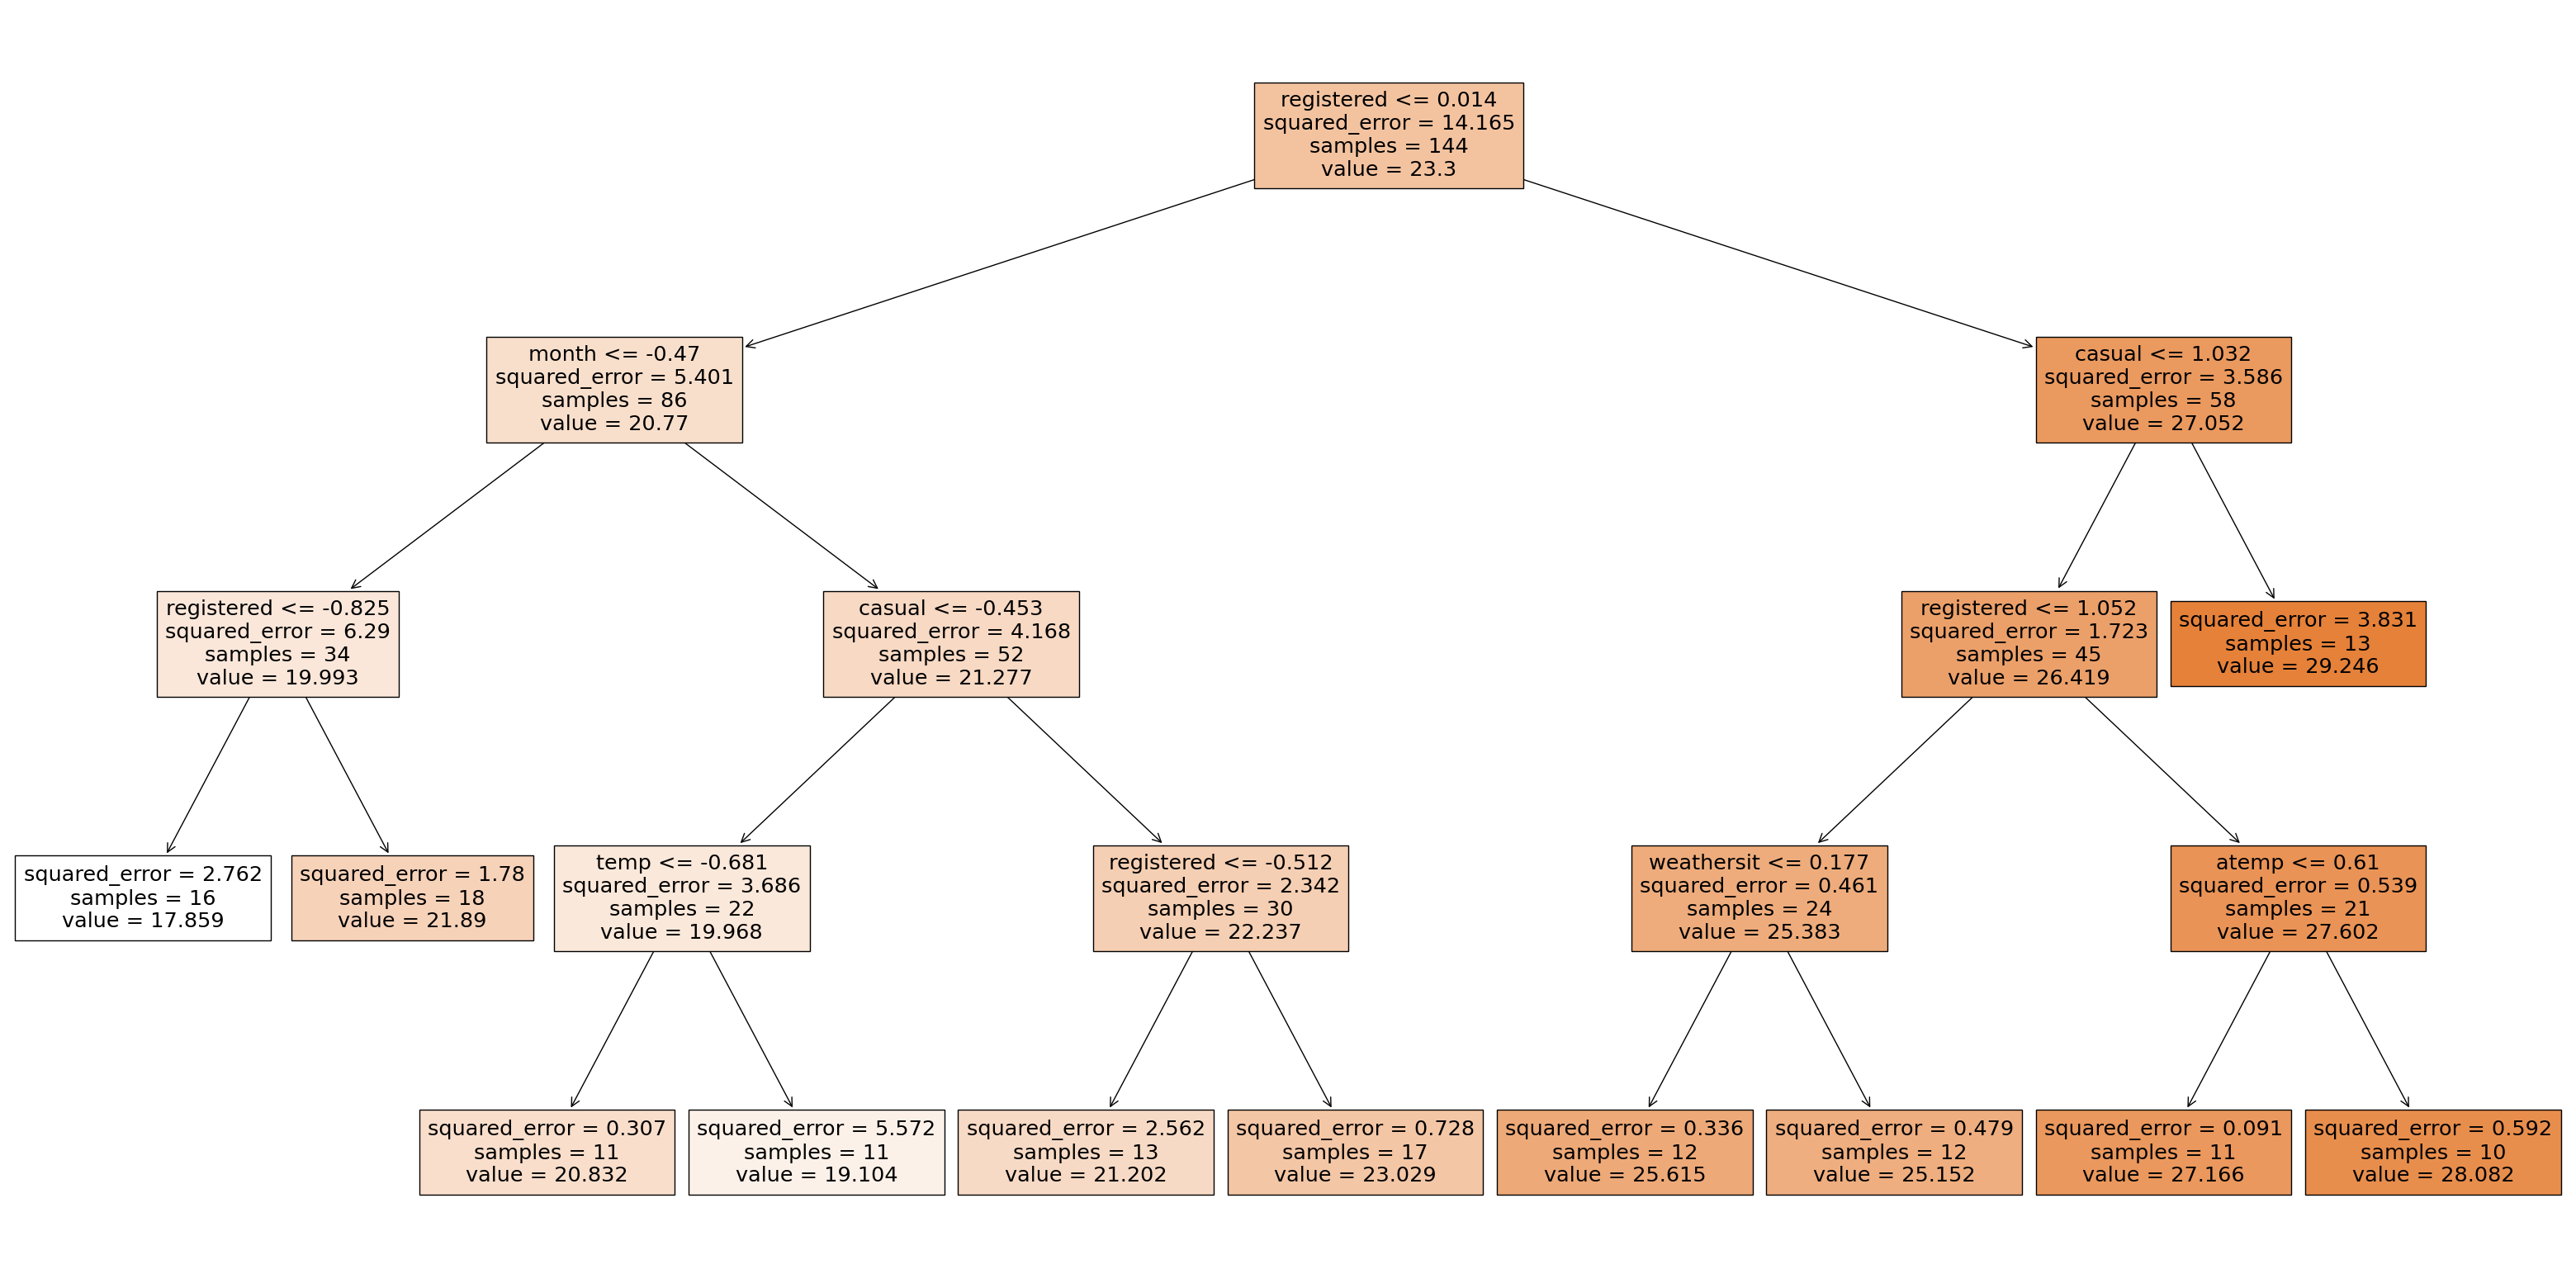

In [22]:

# veamos ahora que pinta tiene nuestro árbol

fig = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo, feature_names=x_train.columns, filled=True);


In [23]:
#MÉTRICAS PARA COMPROBAR LA CALIDAD DEL MODELO

y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)


dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
dt_results2



,MAE,MSE,RMSE,R2,set,modelo
0,1.047885,2.004568,1.415828,0.846777,test,Decision tree II
1,0.964701,1.757613,1.325750,0.875919,train,Decision tree II


In [24]:

# vamos  a juntar los dataframes de los resultados de los modelos para poder compararlos mejor

df_decision_results = pd.concat([dt_results1, dt_results2], axis = 0)
df_decision_results


,MAE,MSE,RMSE,R2,set,modelo
0,0.529329,0.620632,0.787802,0.952561,test,Decission Tree I
1,0.000000,0.000000,0.000000,1.000000,train,Decission Tree I
0,1.047885,2.004568,1.415828,0.846777,test,Decision tree II
1,0.964701,1.757613,1.325750,0.875919,train,Decision tree II


In [29]:
df_decision_results.to_csv('datos/bikes_DT.csv')

In [ ]:
# En invierno se podría utilizar el segundo modelo de predicción, ya que se ajusta un poco más. 
# El otro es demasiado automático.

In [25]:

# COMPROBACIÓN DE LA IMPORTANCIA DE VARIABLES PREDICTORAS

# vamos a crearnos un dataframe 
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': mejor_modelo.feature_importances_}
                            )



In [26]:

# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)


In [27]:


# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores



Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
12,registered,0.886957
11,casual,0.081705
2,month,0.018966
7,temp,0.009195
8,atemp,0.002457
6,weathersit,0.000720
0,season,0.000000
1,year,0.000000
3,holiday,0.000000
4,weekday,0.000000


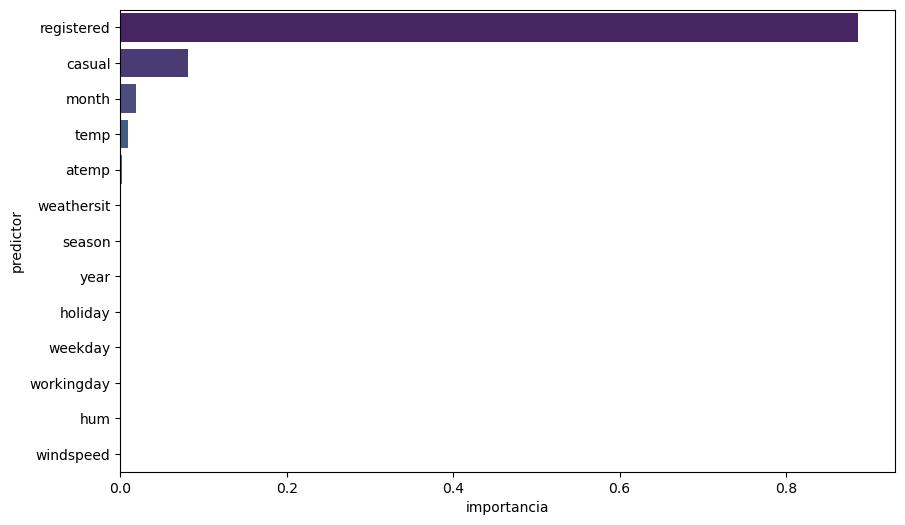

In [28]:

# por último ploteamos los resultados para verlo de una forma más amigable. 

plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis")
plt.show();
